## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from glob import glob
import os
import random
from IPython.display import HTML
import gc
import shutil
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pywt
from scipy.signal import freqz
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from sklearn.decomposition import PCA
from scipy.fftpack import fft, ifft
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Malis project anasuya/grasp-and-lift-eeg-detection"
!ls 

/content/drive/MyDrive/Malis project anasuya/grasp-and-lift-eeg-detection
sample_submission.csv  submission2.csv	test
submission1.csv        submission.csv	train


## Data Exploration

In [ ]:
train_set_labels = pd.read_csv("train/train/subj1_series1_events.csv")
train_set_signals = pd.read_csv("train/train/subj1_series1_data.csv")
train_set_signals.head(5)

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


HandStart = red
FirstDigitTouch = purple
BothStartLoadPhase = black
LiftOff = green
Replace = yellow
BothReleased = blue


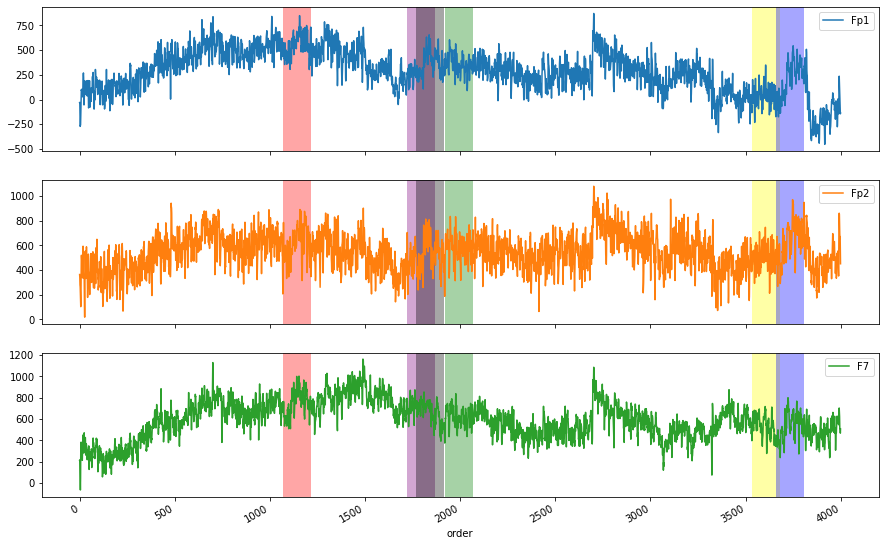

In [ ]:
eeg_channels = train_set_signals.columns.drop('id')
labels = train_set_labels.columns.drop('id')
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1
secondsToShow = 8
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","purple","black","green", "yellow", "blue"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,10))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
plt.show()

## Data Pre-processing

In [ ]:
def butter_lowpass_filter(data, lowcut, fs, order):
    b, a = butter(order, lowcut/(0.5*fs), btype='lowpass')
    y = lfilter(b, a, data)
    return y

def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * np.mean(np.absolute(coeff[-level] - np.mean(coeff[-level], None)), None)
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')[:len(x)]

def prepare_data(fname, train_flag):
    if train_flag:
      data = pd.read_csv(fname)
      labels= pd.read_csv(fname.replace('_data','_events'))
      data=data.drop(['id' ], axis=1)
      labels=labels.drop(['id' ], axis=1)
      return  data, labels
    else:
      data = pd.read_csv(fname)
      return data

def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

def stack_butter_features(X): # Creating features and stacking them
    for col in [0, 1, 2]: # 3 most informative features chosen from PCA 
        F = []
        for fc in np.linspace(0,1,11)[1:]:
          b, a = butter(3, fc/250, btype="lowpass")
          F.append(lfilter(b, a, X[:, col]).reshape(-1,1))
        F = np.concatenate(F, axis=1)
        X = np.concatenate((X, F, F**2), axis=1)
    return X

In [ ]:
scaler = StandardScaler()
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']
subjects = range(1,13)
downsample = 100

### 1. Logistic Regression

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2
for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)

    fs = 500.0
    lowcut = 7.0
    highcut = 30.0
    
    if (preproc_mode == 0):
      #X_train_de=butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3)
      #print(X_train_de)
      #X_test_de=butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3)
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised=np.append(X_train_denoised, butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          print(X_train_denoised)
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised=np.append(X_test_denoised, butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
    #X_train_denoised=X_train_denoised.reshape(-1,1)
    #X_test_denoised= X_test_denoised.reshape(-1,1)
    print(X_train_denoised)   
    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    lr = LogisticRegression()
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      lr.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = lr.predict_proba(X_test)[:,1]
      pred_t[:, i] = lr.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

[[-3.10000000e+01  3.63000000e+02  2.11000000e+02 ...  7.03839998e-10
   1.42332275e-09  2.67155014e-09]
 [-2.90000000e+01  3.42000000e+02  2.16000000e+02 ...  3.45235496e-08
   6.97642839e-08  1.30852257e-07]
 [-1.72000000e+02  2.78000000e+02  1.05000000e+02 ...  4.21745258e-07
   8.51462909e-07  1.59555358e-06]
 ...
 [ 1.40000000e+02  3.50000000e+02  3.71000000e+02 ...  1.43123090e+05
   1.48777807e+05  1.48985342e+05]
 [ 1.45000000e+02  3.23000000e+02  3.80000000e+02 ...  1.43126585e+05
   1.48647512e+05  1.48720942e+05]
 [ 1.44000000e+02  2.65000000e+02  4.00000000e+02 ...  1.43127388e+05
   1.48514473e+05  1.48454660e+05]]
Train subject 1, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 1, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 1, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 1, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 1, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 1, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[ 6.42000000e+02  1.65000000e+02 -2.91000000e+02 ...  1.33873621e-09
   2.70722566e-09  5.08141185e-09]
 [ 6.41000000e+02  1.80000000e+02 -2.69000000e+02 ...  6.38165580e-08
   1.28957496e-07  2.41874554e-07]
 [ 6.52000000e+02  2.49000000e+02 -3.06000000e+02 ...  7.99567606e-07
   1.61427837e-06  3.02504480e-06]
 ...
 [ 2.56000000e+02  4.53000000e+02  6.31000000e+02 ...  4.30479136e+05
   4.36174654e+05  4.37910481e+05]
 [ 2.97000000e+02  5.77000000e+02  6.64000000e+02 ...  4.30914524e+05
   4.36582700e+05  4.38367103e+05]
 [ 3.05000000e+02  6.38000000e+02  7.05000000e+02 ...  4.31349196e+05
   4.36990518e+05  4.38823637e+05]]
Train subject 2, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 2, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 2, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 2, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 2, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 2, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[1.00100000e+03 8.40000000e+01 1.10300000e+03 ... 1.92335769e-08
  3.88946175e-08 7.30044685e-08]
 [9.69000000e+02 7.50000000e+01 1.08600000e+03 ... 9.32905430e-07
  1.88518323e-06 3.53589935e-06]
 [9.60000000e+02 2.80000000e+01 1.06500000e+03 ... 1.17463180e-05
  2.37152389e-05 4.44409565e-05]
 ...
 [5.03000000e+02 4.59000000e+02 5.78000000e+02 ... 3.12848584e+05
  3.22688509e+05 3.31747911e+05]
 [5.12000000e+02 4.51000000e+02 6.20000000e+02 ... 3.13269491e+05
  3.23135987e+05 3.32214522e+05]
 [4.87000000e+02 4.54000000e+02 6.01000000e+02 ... 3.13689782e+05
  3.23582100e+05 3.32678731e+05]]
Train subject 3, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 3, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 3, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 3, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 3, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 3, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[ 7.08000000e+02  8.85000000e+02  1.05300000e+03 ...  1.75293485e-08
   3.54482845e-08  6.65357659e-08]
 [ 7.79000000e+02  7.97000000e+02  1.06100000e+03 ...  8.55871031e-07
   1.72951888e-06  3.24393891e-06]
 [ 8.19000000e+02  7.97000000e+02  1.13100000e+03 ...  1.09198138e-05
   2.20468177e-05  4.13149032e-05]
 ...
 [ 1.65000000e+02 -1.17000000e+02  3.35000000e+02 ...  2.06318962e+05
   2.04386668e+05  2.04956626e+05]
 [ 1.22000000e+02 -1.59000000e+02  3.71000000e+02 ...  2.06451116e+05
   2.04591527e+05  2.05255566e+05]
 [ 2.17000000e+02 -1.02000000e+02  4.00000000e+02 ...  2.06584444e+05
   2.04797753e+05  2.05555525e+05]]
Train subject 4, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 4, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 4, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 4, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 4, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 4, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[6.50000000e+01 4.65000000e+02 1.80000000e+01 ... 5.12217065e-12
  1.03581809e-11 1.94421115e-11]
 [5.90000000e+01 4.74000000e+02 3.20000000e+01 ... 3.08259758e-10
  6.22966710e-10 1.16853909e-09]
 [3.40000000e+01 4.82000000e+02 2.70000000e+01 ... 4.60699826e-09
  9.30271888e-09 1.74354016e-08]
 ...
 [6.47000000e+02 2.62000000e+02 6.74000000e+02 ... 1.81995190e+05
  1.84600873e+05 1.86580252e+05]
 [6.43000000e+02 2.36000000e+02 6.70000000e+02 ... 1.82125431e+05
  1.84778611e+05 1.86793374e+05]
 [6.54000000e+02 2.45000000e+02 6.81000000e+02 ... 1.82259745e+05
  1.84961502e+05 1.87013119e+05]]
Train subject 5, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 5, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 5, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 5, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 5, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 5, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[1.81000000e+02 3.19000000e+02 2.18000000e+02 ... 7.51314931e-10
  1.51932774e-09 2.85174971e-09]
 [1.76000000e+02 3.04000000e+02 2.23000000e+02 ... 3.68442013e-08
  7.44537902e-08 1.39648043e-07]
 [2.26000000e+02 3.14000000e+02 2.76000000e+02 ... 4.78728072e-07
  9.66553950e-07 1.81131284e-06]
 ...
 [1.41000000e+02 2.45000000e+02 5.01000000e+02 ... 2.13553594e+05
  2.23065752e+05 2.26588752e+05]
 [5.60000000e+01 2.73000000e+02 4.78000000e+02 ... 2.13853711e+05
  2.23250039e+05 2.26669763e+05]
 [1.98000000e+02 4.16000000e+02 5.46000000e+02 ... 2.14151931e+05
  2.23432673e+05 2.26750055e+05]]
Train subject 6, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 6, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 6, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 6, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 6, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 6, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-5.40000000e+01 -5.23000000e+02  2.57100000e+03 ...  1.04499253e-07
   2.11320988e-07  3.96645537e-07]
 [-5.90000000e+01 -5.48000000e+02  2.58200000e+03 ...  5.09733394e-06
   1.03005382e-05  1.93200003e-05]
 [-1.33000000e+02 -5.50000000e+02  2.58600000e+03 ...  6.46385720e-05
   1.30502925e-04  2.44556317e-04]
 ...
 [-5.70000000e+01 -1.25000000e+02  2.59000000e+02 ...  2.09728137e+05
   1.80378242e+05  1.67713104e+05]
 [-5.50000000e+01 -1.27000000e+02  2.67000000e+02 ...  2.08893079e+05
   1.79779652e+05  1.67315866e+05]
 [-3.00000000e+00 -1.11000000e+02  3.07000000e+02 ...  2.08062146e+05
   1.79184645e+05  1.66920282e+05]]
Train subject 7, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 7, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 7, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 7, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 7, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 7, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-1.10000000e+01 -1.08000000e+02  4.40000000e+02 ...  3.06065505e-09
   6.18933277e-09  1.16172617e-08]
 [ 1.80000000e+01 -7.30000000e+01  4.69000000e+02 ...  1.51941138e-07
   3.07039989e-07  5.75897098e-07]
 [ 1.60000000e+01 -6.60000000e+01  4.56000000e+02 ...  1.95442767e-06
   3.94597056e-06  7.39466039e-06]
 ...
 [ 6.70000000e+01  1.19000000e+02  4.61000000e+02 ...  2.05885485e+05
   2.08757893e+05  2.13579537e+05]
 [ 5.60000000e+01  9.40000000e+01  4.61000000e+02 ...  2.06143412e+05
   2.09080434e+05  2.13965119e+05]
 [ 3.60000000e+01  9.40000000e+01  4.48000000e+02 ...  2.06404072e+05
   2.09406414e+05  2.14354655e+05]]
Train subject 8, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 8, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 8, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 8, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 8, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 8, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-7.45000000e+02  5.52000000e+02 -1.26100000e+03 ...  2.51384911e-08
   5.08356819e-08  9.54176226e-08]
 [-7.96000000e+02  5.85000000e+02 -1.29500000e+03 ...  1.23420036e-06
   2.49404055e-06  4.67790863e-06]
 [-7.49000000e+02  6.02000000e+02 -1.24300000e+03 ...  1.56943589e-05
   3.16864314e-05  5.93790482e-05]
 ...
 [-8.70000000e+01  2.60000000e+01  1.20000000e+02 ...  3.30668037e+03
   5.43179745e+03  7.47901838e+03]
 [-3.50000000e+01  9.00000000e+01  1.82000000e+02 ...  3.37426421e+03
   5.51597284e+03  7.57183269e+03]
 [-4.30000000e+01  1.27000000e+02  1.92000000e+02 ...  3.44246775e+03
   5.60062565e+03  7.66494366e+03]]
Train subject 9, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 9, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 9, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 9, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 9, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 9, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-3.04000000e+02 -1.56000000e+02 -4.11000000e+02 ...  2.67050058e-09
   5.40035269e-09  1.01363608e-08]
 [-3.00000000e+02 -1.51000000e+02 -3.76000000e+02 ...  1.26948603e-07
   2.56531501e-07  4.81153727e-07]
 [-2.86000000e+02 -2.27000000e+02 -4.00000000e+02 ...  1.57733910e-06
   3.18452915e-06  5.96754261e-06]
 ...
 [ 1.55000000e+02 -2.05000000e+02  2.15000000e+02 ...  1.08433948e+05
   8.61038170e+04  6.36277902e+04]
 [ 8.40000000e+01 -2.67000000e+02  2.04000000e+02 ...  1.07783325e+05
   8.54545995e+04  6.31172198e+04]
 [ 3.10000000e+01 -2.18000000e+02  2.22000000e+02 ...  1.07137347e+05
   8.48133409e+04  6.26163288e+04]]
Train subject 10, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 10, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 10, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 10, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 10, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 10, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-3.05000000e+03 -1.27500000e+03 -8.23000000e+02 ...  1.07080084e-08
   2.16540009e-08  4.06441540e-08]
 [-3.05700000e+03 -1.26700000e+03 -9.08000000e+02 ...  5.37235366e-07
   1.08563990e-06  2.03627946e-06]
 [-3.04200000e+03 -1.24300000e+03 -9.67000000e+02 ...  7.03511742e-06
   1.42040511e-05  2.66184809e-05]
 ...
 [-1.91000000e+02 -1.50000000e+01  4.36000000e+02 ...  1.69979773e+05
   1.71240853e+05  1.68474238e+05]
 [-1.45000000e+02  5.90000000e+01  5.23000000e+02 ...  1.70094227e+05
   1.71292270e+05  1.68509632e+05]
 [-1.25000000e+02  1.54000000e+02  5.27000000e+02 ...  1.70208973e+05
   1.71345114e+05  1.68547860e+05]]
Train subject 11, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 11, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 11, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 11, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 11, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 11, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[-5.42000000e+02  1.14000000e+02 -2.63000000e+02 ...  1.09350439e-09
   2.21131177e-09  4.15059076e-09]
 [-5.70000000e+02  8.00000000e+01 -2.85000000e+02 ...  5.45589306e-08
   1.10251928e-07  2.06793518e-07]
 [-6.35000000e+02  4.40000000e+01 -3.25000000e+02 ...  7.15257622e-07
   1.44412080e-06  2.70629239e-06]
 ...
 [ 7.27000000e+02  2.44900000e+03  4.13000000e+02 ...  3.54144459e+05
   3.41693921e+05  3.24513828e+05]
 [ 6.26000000e+02  2.57800000e+03  3.74000000e+02 ...  3.53929247e+05
   3.41288621e+05  3.24056114e+05]
 [ 6.72000000e+02  2.62700000e+03  3.68000000e+02 ...  3.53710291e+05
   3.40882281e+05  3.23600012e+05]]
Train subject 12, class HandStart


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 12, class FirstDigitTouch


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 12, class BothStartLoadPhase


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 12, class LiftOff


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 12, class Replace


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train subject 12, class BothReleased


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### ROC curves of training data

AUC ROC score :  0.9048783058758452


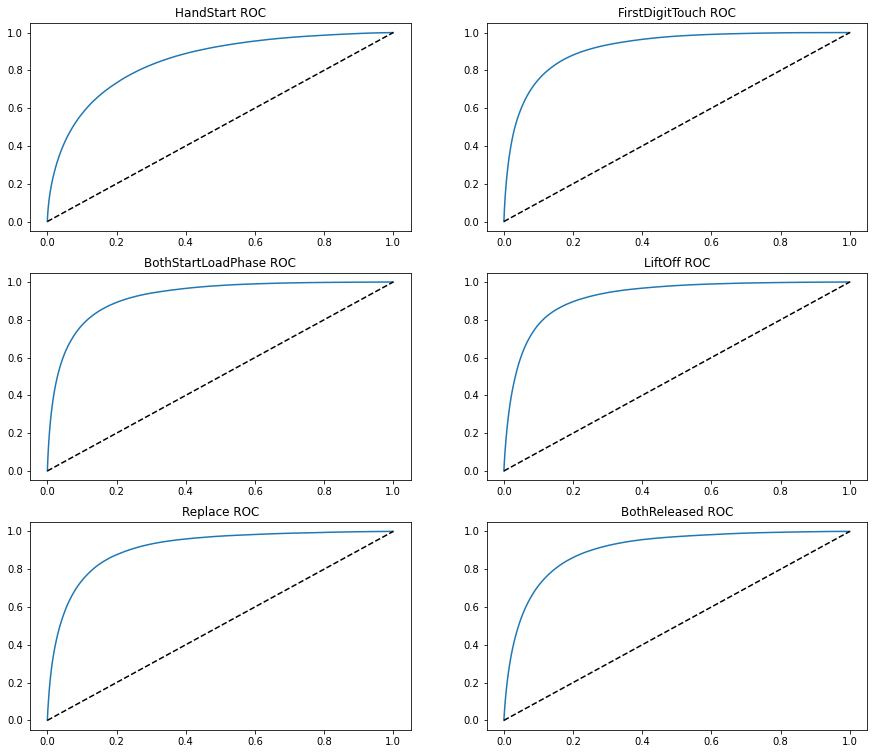

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')


rm: cannot remove 'submission.csv': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


#### ROC Score for hidden data on Kaggle: 0.87406




###2. Linear Discriminant Analysis

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    lda = LDA()
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      lda.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = lda.predict_proba(X_test)[:,1]
      pred_t[:, i] = lda.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

#### ROC Curves of training data

AUC ROC score :  0.9100582233718089


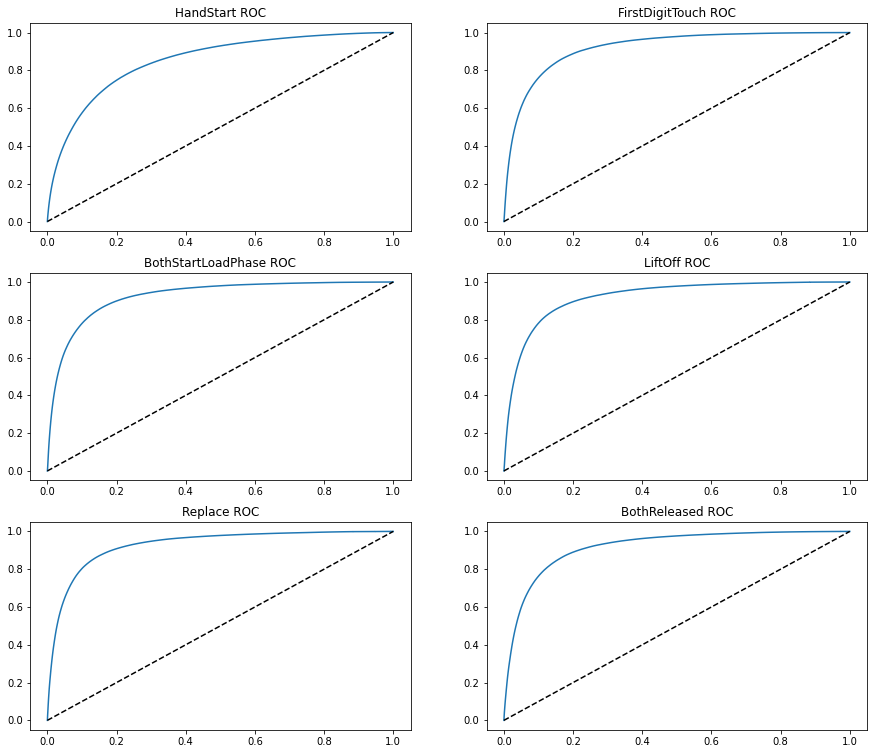

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:

submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission1.csv',index_label='id',float_format='%.3f')


'\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 /root/.kaggle/kaggle.json\n!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "LDA with triple stacked butter"\n'

#### ROC Score for hidden data on Kaggle: 0.88596

### 3. Random Forest Classifier

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    rf = RandomForestClassifier(n_estimators=200, max_depth=7, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      rf.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = rf.predict_proba(X_test)[:,1]
      pred_t[:, i] = rf.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

#### ROC Curves of training data

AUC ROC score :  0.9347495744506187


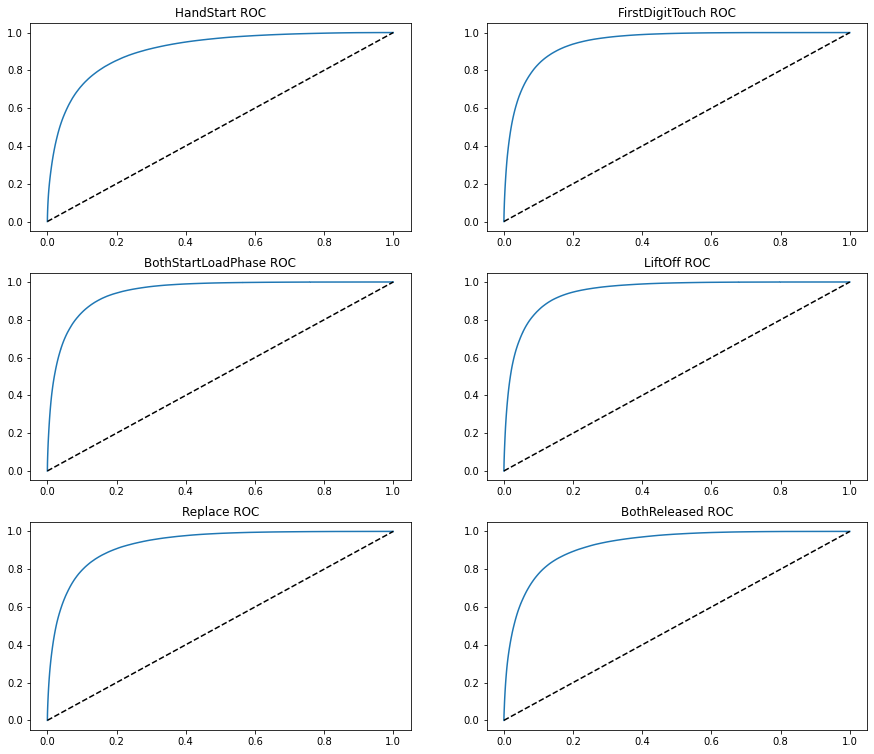

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission2.csv',index_label='id',float_format='%.3f')

'\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 /root/.kaggle/kaggle.json\n!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "RF with triple stacked butter"\n'

#### ROC Score for hidden data on Kaggle: 0.80557

### 4. PCA with Random Forests

In [ ]:
columns = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9',
           'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2
compdata = []
pca = PCA(n_components=10)
for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
  
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    compdata.append(np.argmax(pca.components_, axis=1))

    rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      rf.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = rf.predict_proba(X_test)[:,1]
      pred_t[:, i] = rf.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

#### ROC Curves of training data

AUC ROC score :  0.8870008650517757


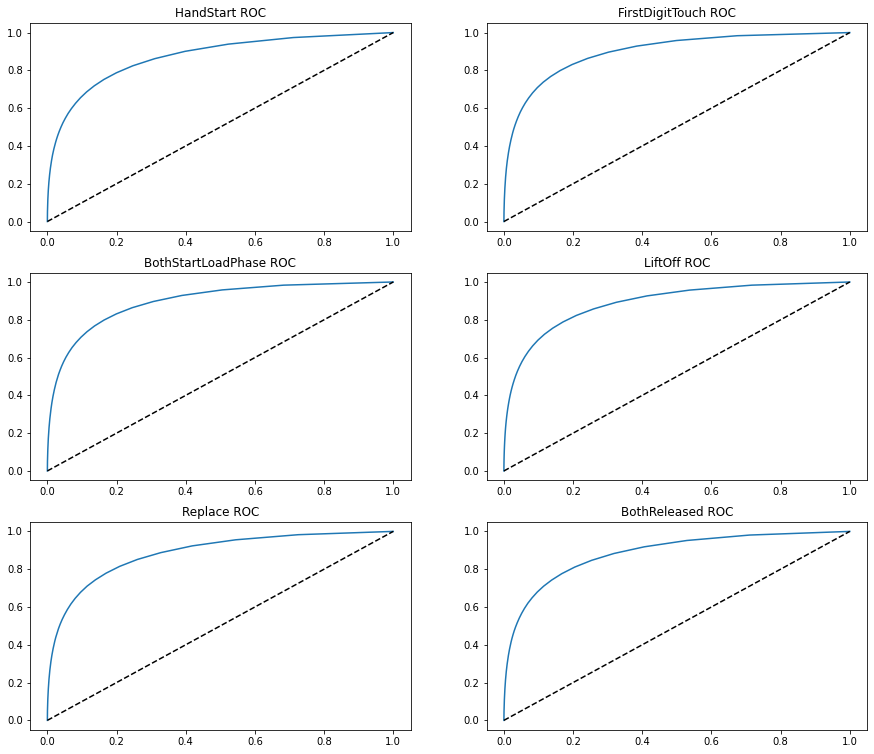

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
df = pd.DataFrame(compdata, columns = ['Imp 1', 'Imp 2', 'Imp 3', 'Imp 4', 'Imp 5', 'Imp 6', 'Imp 7', 'Imp 8', 'Imp 9', 'Imp 10', 'Imp 11', 'Imp 12'])
df

,Imp 1,Imp 2,Imp 3,Imp 4,Imp 5,Imp 6,Imp 7,Imp 8,Imp 9,Imp 10,Imp 11,Imp 12
0,87,38,47,24,71,1,52,50,55,10,6,27
1,37,49,86,43,84,70,61,45,52,6,3,8
2,57,84,46,19,32,14,52,7,13,42,5,3
3,78,65,49,75,67,52,91,11,3,8,3,17
4,38,62,86,45,69,68,9,51,21,4,0,3
5,78,69,85,44,48,19,5,32,62,18,11,14
6,37,68,68,84,91,4,45,8,32,66,9,53
7,88,48,48,61,91,40,4,6,32,65,10,11
8,36,46,28,85,42,5,4,40,5,3,19,82
9,78,48,30,70,88,44,51,41,24,32,33,15


In [ ]:
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')


rm: cannot remove 'submission.csv': No such file or directory
100% 171M/171M [00:13<00:00, 13.2MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.65264

### 5.  Ensemble of LDA + Random Forest + Logistic Regression

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    model1 = LDA()
    model2 = LogisticRegression()
    model3 = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0],6))

    pred_t = np.empty((X_train.shape[0], 6))
    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      model1.fit(X_train[::downsample,:],y[::downsample])
      model2.fit(X_train[::downsample,:],y[::downsample])
      model3.fit(X_train[::downsample,:],y[::downsample])

      pred[:, i] = ((model1.predict_proba(X_test)[:,1])*0.4
                  +(model2.predict_proba(X_test)[:,1])*0.35
                  +(model3.predict_proba(X_test)[:,1])*0.25)

      pred_t[:, i] = ((model1.predict_proba(X_train)[:,1])*0.4
                    +(model2.predict_proba(X_train)[:,1])*0.35
                    +(model3.predict_proba(X_train)[:,1])*0.25)
    pred_tot.append(pred)
    pred_train_tot.append(pred_t)

#### ROC Curves of training data

AUC ROC score :  0.9601044814714378


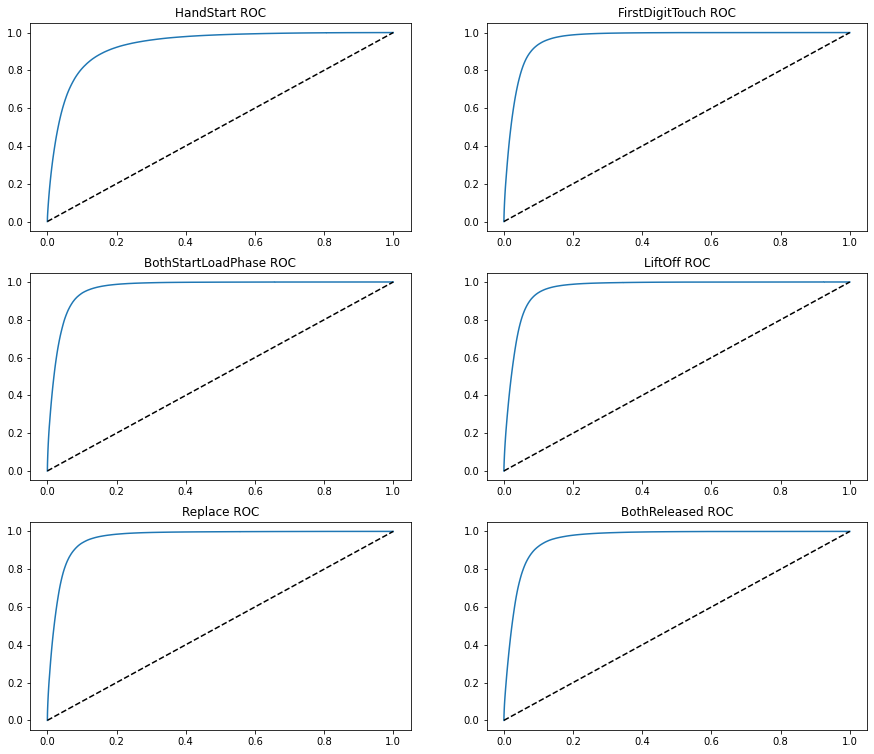

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')

100% 171M/171M [00:12<00:00, 14.1MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.88507



### Comparing our pre-processing methods: Wavelet Denoising vs Butter Lowpass filter

In [ ]:
data = [['LR', 'Butter Lowpass', 0.72848], 
        ['LR', 'Wavelet', 0.72057], 
        ['LR', 'Stacked Lowpass', 0.87406], 
        ['LR', 'Vanilla', 0.71479], 
        ['LDA', 'Butter Lowpass', 0.72428],
        ['LDA', 'Wavelet', 0.71732],
        ['LDA', 'Stacked Lowpass', 0.88596],
        ['LDA', 'Vanilla', 0.71124],
        ['RF', 'Butter Lowpass', 0.67852],
        ['RF', 'Wavelet', 0.71368],
        ['RF', 'Stacked Lowpass', 0.81046],
        ['RF', 'Vanilla', 0.69682],
        ['RF & PCA', 'Butter Lowpass', 0.65264],
        ['RF & PCA', 'Wavelet', 0.65625],
        ['RF & PCA', 'Stacked Lowpass', 0.65264],
        ['RF & PCA', 'Vanilla', 0.69682],
        ['LD+R+L', 'Butter Lowpass', 0.74772],
        ['LD+R+L', 'Stacked Lowpass', 0.88507]]

df = pd.DataFrame(data, columns = ['Algorithm', 'type', 'score'])

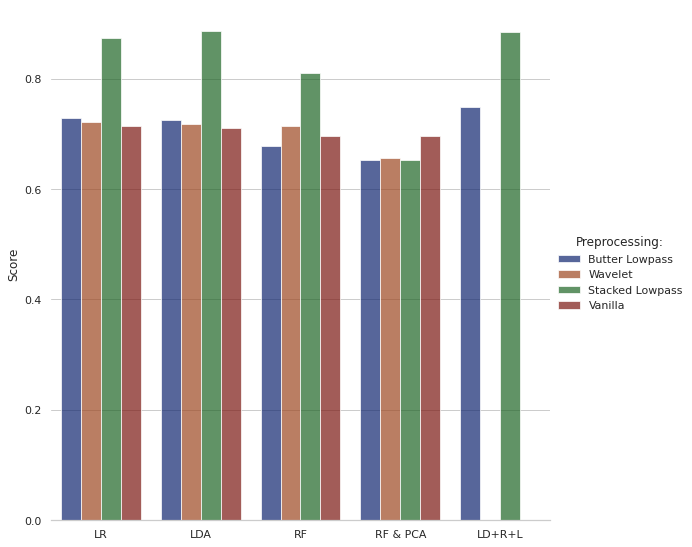

In [ ]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df, kind="bar",
    x="Algorithm", y="score", hue="type",
    ci="sd", palette="dark", alpha=.7, height=8
)
g.despine(left=True)
g.set_axis_labels("", "Score")
g.legend.set_title("Preprocessing:")
